In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [34]:
data_paths = ['out_2024-03-25-10-31-23_one_person_moving',
              'out_2024-03-25-10-34-45_two_people_moving',
              'out_2024-03-25-10-32-56_one_standing_one_moving',
              'out_2024-03-25-10-37-34_two_in_parallel']

topics = ['/_qualisys_pedestrian_pose.csv', '/_qualisys_pedestrian_velocity.csv',
'/_objectposes.csv', '/_person_state_estimation_person_states.csv']

### Time (x-axis) vs Y coordinate (y-axis) of ground truth, objectpose, personstate_prediction

/tmp/ipykernel_183120/1933607321.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.cm.get_cmap('tab10')


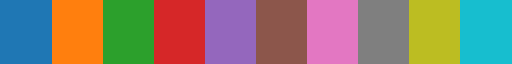

In [35]:
plt.cm.get_cmap('tab10')

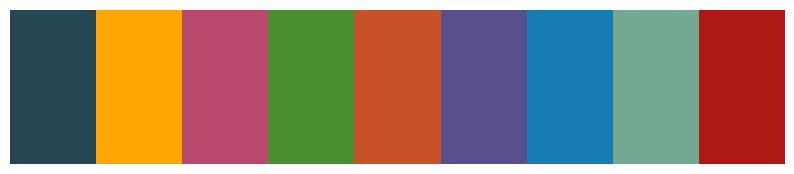

In [36]:
import matplotlib.patches as patches

COLORS = ['#264653', '#ffa600','#b8496c', '#488f31',  '#c7522a',  '#58508d', '#177cb3', '#74a892', '#ad1714']

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 2))  # Figure size can be adjusted

# Remove axes
ax.axis('off')

# Plot each color as a rectangle patch and print the hex code
for i, color in enumerate(COLORS):
    # Create a rectangle patch and add it to the axes
    rect = patches.Rectangle((i, 0), 1, 1, linewidth=1, edgecolor='none', facecolor=color)
    ax.add_patch(rect)
# Set the axes limits to fit the patches
ax.set_xlim(0, len(COLORS))
ax.set_ylim(0, 1)

plt.show()

In [37]:
def read_data(file_path, topic):    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path + topic)

    # Converting stamp_secs to a readable datetime format for plotting
    # df["time"] = pd.to_datetime(df["'header.stamp.secs"], unit='s')
    df['time'] = pd.to_datetime(df['header.stamp.secs'], unit='s') + pd.to_timedelta(df['header.stamp.nsecs'], unit='ns')
    df = df.sort_values(by='time')
    if topic == '/_objectposes.csv':
        df = df[df['objects.object.label'] == 'person']

    return df

def get_topic_data(topic):
    if topic == '/_objectposes.csv':
        person_id_col = 'objects.object.id'
        topic_x = 'objects.pose.pose.position.x'
        topic_y = 'objects.pose.pose.position.y'
        topic_label = 'Objectpose'
        alpha = 0.6
    elif topic == '/_person_state_estimation_person_states.csv':
        person_id_col = 'personstate.id'
        topic_x = 'personstate.pose.position.x'
        topic_y = 'personstate.pose.position.y'
        topic_label = 'Personstate'
        alpha = 0.9
    elif topic == '/_qualisys_pedestrian_pose.csv':
        person_id_col = ''
        topic_x = 'pose.position.x'
        topic_y = 'pose.position.y'
        topic_label = 'GroundTruth'
        alpha = 0.5

    return person_id_col, topic_x, topic_y, topic_label, alpha


def plot_topic_for_persons(df, person_id_col, topic, xaxis, yaxis, marker, ax, alpha=0.7):
    # Get unique person IDs
    if person_id_col in df.columns:
        unique_person_ids = df[person_id_col].dropna().unique()
        id_colors = {str(id_): COLORS[i] for i, id_ in enumerate(unique_person_ids)}
        id_colors[str(np.nan)] = 'black'
        for person_id in unique_person_ids:
            person_df = df[df[person_id_col] == person_id]
            ax.scatter(person_df[xaxis], person_df[yaxis], label=f'ID {person_id}/ {topic}', color=id_colors[str(person_id)], edgecolor='black', marker=marker, alpha=alpha, s=20)
    else:
        color = "#ad1714" if 'pedestrian' in topic else '#560B0A'
        ax.scatter(df[xaxis], df[yaxis], label=f'ID - / {topic}', color=color, alpha=alpha, s=20, marker=marker)
   

def plot_topic_for_persons_direction(df, person_id_col, topic, xaxis, yaxis, marker, ax, alpha=0.7):
    # Define colors for NaN and a fallback color
    nan_color = 'black'
    fallback_color = "#ad1714" if 'pedestrian' in topic else '#560B0A'
    
    # Check if person_id_col exists in the dataframe and has valid data
    if person_id_col in df.columns:
        unique_person_ids = df[person_id_col].dropna().unique()
        
        # Prepare colors for each ID, ensuring a unique color is used and assign one for NaN
        id_colors = {str(id_): COLORS[i % len(COLORS)] for i, id_ in enumerate(unique_person_ids)}
        id_colors[str(np.nan)] = nan_color
        
        for person_id in unique_person_ids:
            person_df = df[df[person_id_col] == person_id]
            
            # Extract x and y values
            x_values = person_df[xaxis].values
            y_values = person_df[yaxis].values
            
            # Plot arrows for direction
            for i in range(len(x_values)-1):
                ax.annotate('', xy=(x_values[i+1], y_values[i+1]), xytext=(x_values[i], y_values[i]),
                            arrowprops=dict(arrowstyle="->", color=id_colors[str(person_id)], alpha=alpha),
                            alpha=alpha)
            
            # Also scatter plot to show the points clearly
            ax.scatter(x_values, y_values, label=f'ID {person_id} / {topic}', color=id_colors[str(person_id)], alpha=alpha, s=20, marker=marker)
    else:
        # Extract x and y values
        x_values = df[xaxis].values
        y_values = df[yaxis].values
        
        # Plot arrows for direction
        for i in range(len(x_values)-1):
            ax.annotate('', xy=(x_values[i+1], y_values[i+1]), xytext=(x_values[i], y_values[i]),
                        arrowprops=dict(arrowstyle="->", color=fallback_color, alpha=alpha),
                        alpha=alpha)
        
        # Plot without person IDs
        ax.scatter(x_values, y_values, label=f'ID - / {topic}', color=fallback_color, alpha=alpha, s=20, marker=marker)


In [38]:
# _person_state_estimation_person_states.csv:  header.stamp.secs,header.stamp.nsecs, personstate.id, personstate.pose.position.y, personstate.pose.position.x, personstate.velocity,personstate.direction
# _objectposes.csv: header.stamp.secs,header.stamp.nsecs, objects.pose.pose.position.x,objects.pose.pose.position.y, objects.object.id,objects.object.label
# _qualisys_pedestrian_pose.csv: header.stamp.secs,header.stamp.nsecs, pose.position.x, pose.position.y, pose.orientation.x,pose.orientation.y
# _qualisys_pedestrian_velocity.csv: header.stamp.secs,header.stamp.nsecs, twist.linear.x, twist.linear.y

In [39]:
# _person_state_estimation_person_states.csv: header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,personstate.id,personstate.counter,personstate.pose.position.x,personstate.pose.position.y,personstate.pose.position.z,personstate.pose.orientation.x,personstate.pose.orientation.y,personstate.pose.orientation.z,personstate.pose.orientation.w,personstate.velocity,personstate.direction
# _objectposes.csv: header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,objects.pose.pose.position.x,objects.pose.pose.position.y,objects.pose.pose.position.z,objects.pose.pose.orientation.x,objects.pose.pose.orientation.y,objects.pose.pose.orientation.z,objects.pose.pose.orientation.w,objects.pose.covariance.0,objects.pose.covariance.1,objects.pose.covariance.2,objects.pose.covariance.3,objects.pose.covariance.4,objects.pose.covariance.5,objects.pose.covariance.6,objects.pose.covariance.7,objects.pose.covariance.8,objects.pose.covariance.9,objects.pose.covariance.10,objects.pose.covariance.11,objects.pose.covariance.12,objects.pose.covariance.13,objects.pose.covariance.14,objects.pose.covariance.15,objects.pose.covariance.16,objects.pose.covariance.17,objects.pose.covariance.18,objects.pose.covariance.19,objects.pose.covariance.20,objects.pose.covariance.21,objects.pose.covariance.22,objects.pose.covariance.23,objects.pose.covariance.24,objects.pose.covariance.25,objects.pose.covariance.26,objects.pose.covariance.27,objects.pose.covariance.28,objects.pose.covariance.29,objects.pose.covariance.30,objects.pose.covariance.31,objects.pose.covariance.32,objects.pose.covariance.33,objects.pose.covariance.34,objects.pose.covariance.35,objects.obstacle_width_point_1.x,objects.obstacle_width_point_1.y,objects.obstacle_width_point_1.z,objects.obstacle_width_point_2.x,objects.obstacle_width_point_2.y,objects.obstacle_width_point_2.z,objects.object.id,objects.object.label,objects.object.detection_conf,objects.object.tracking_conf,objects.object.image_width,objects.object.image_height,objects.object.roi.x_offset,objects.object.roi.y_offset,objects.object.roi.height,objects.object.roi.width,objects.object.roi.do_rectify
# _qualisys_pedestrian_pose.csv: header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,pose.position.x,pose.position.y,pose.position.z,pose.orientation.x,pose.orientation.y,pose.orientation.z,pose.orientation.w
# _qualisys_pedestrian_velocity.csv: header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,twist.linear.x,twist.linear.y,twist.linear.z,twist.angular.x,twist.angular.y,twist.angular.z


topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


/tmp/ipykernel_183120/4130447133.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(person_df[xaxis], person_df[yaxis], label=f'ID {person_id}/ {topic}', color=id_colors[str(person_id)], edgecolor='black', marker=marker, alpha=alpha, s=20)


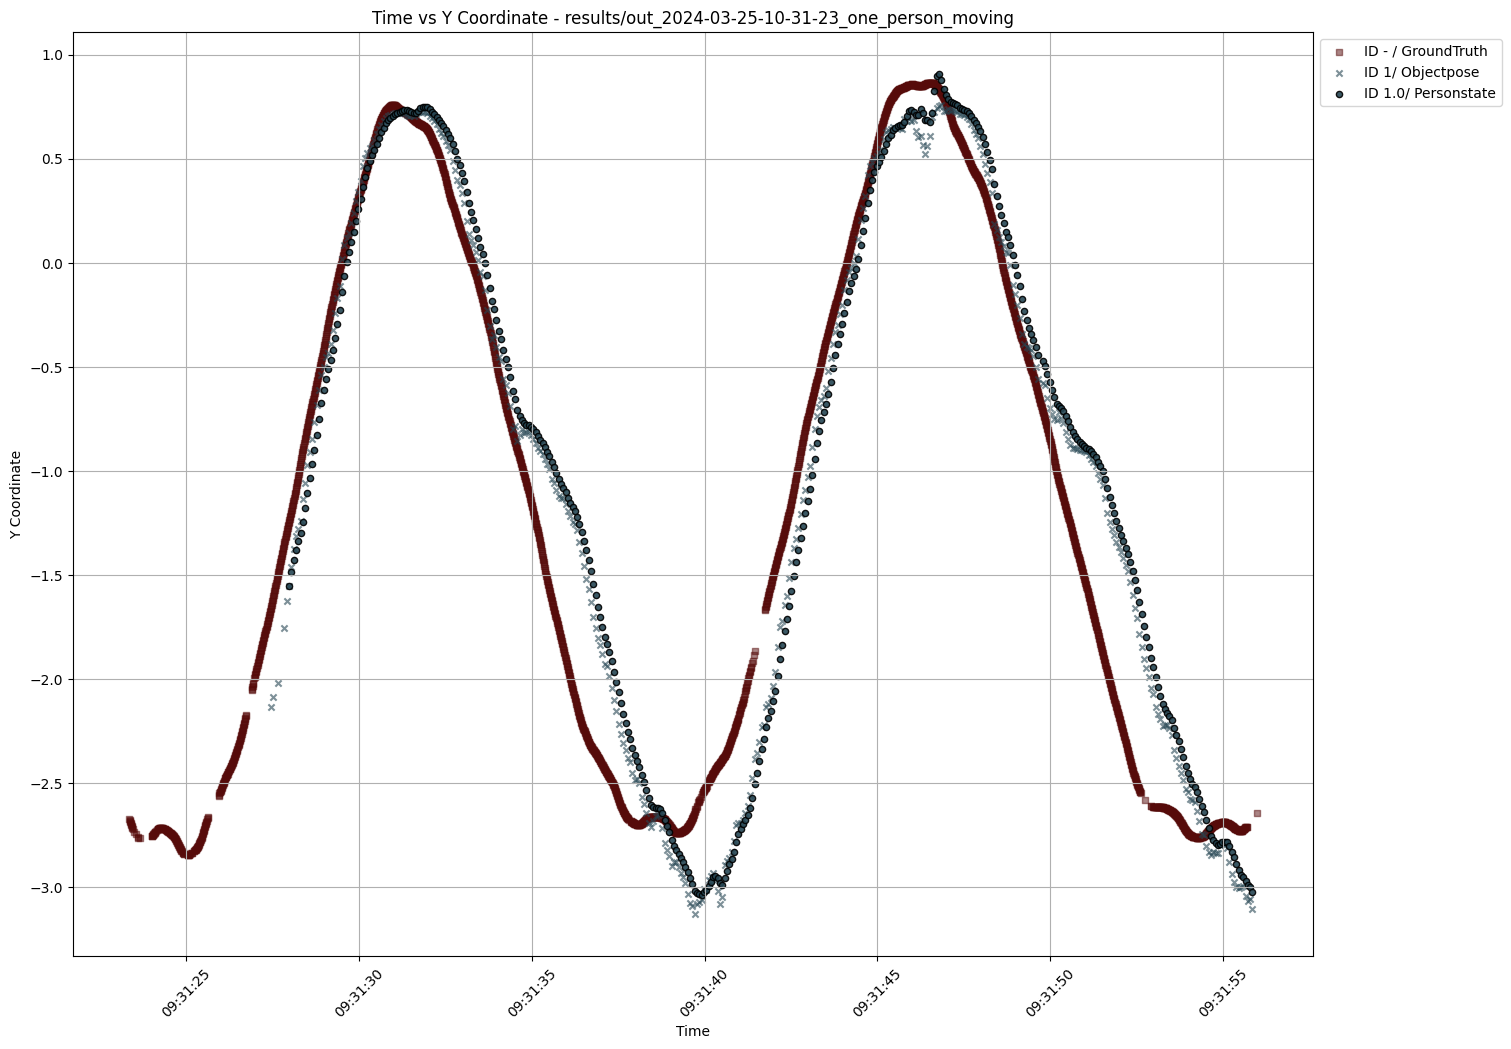

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


/tmp/ipykernel_183120/4130447133.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(person_df[xaxis], person_df[yaxis], label=f'ID {person_id}/ {topic}', color=id_colors[str(person_id)], edgecolor='black', marker=marker, alpha=alpha, s=20)


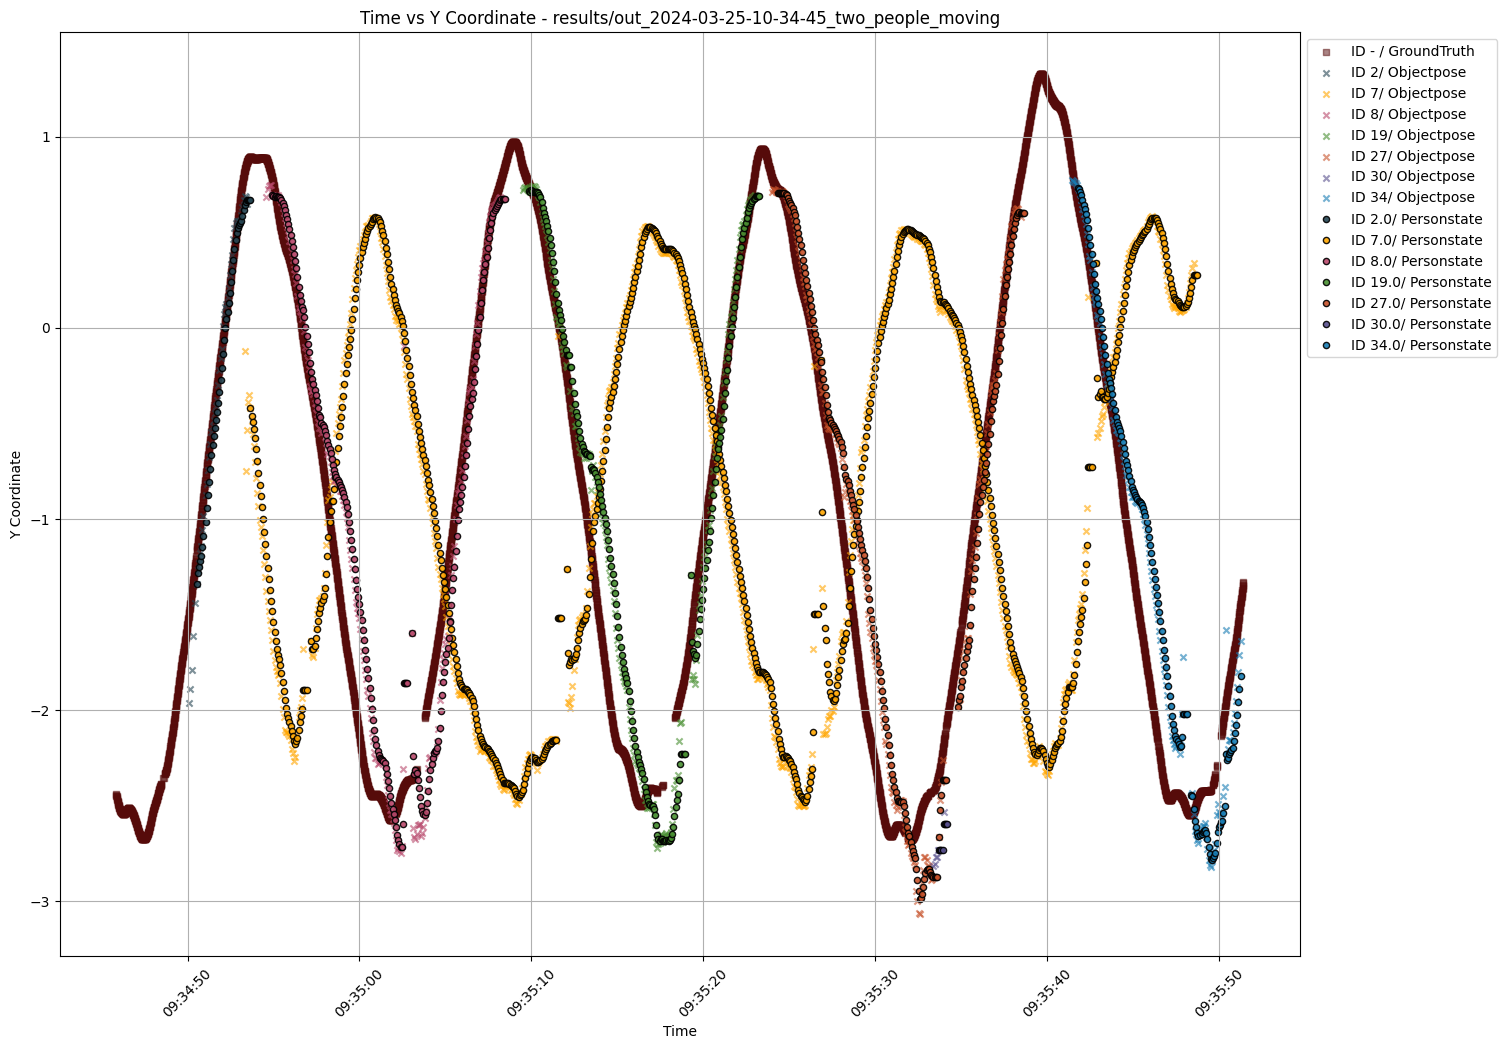

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


/tmp/ipykernel_183120/4130447133.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(person_df[xaxis], person_df[yaxis], label=f'ID {person_id}/ {topic}', color=id_colors[str(person_id)], edgecolor='black', marker=marker, alpha=alpha, s=20)


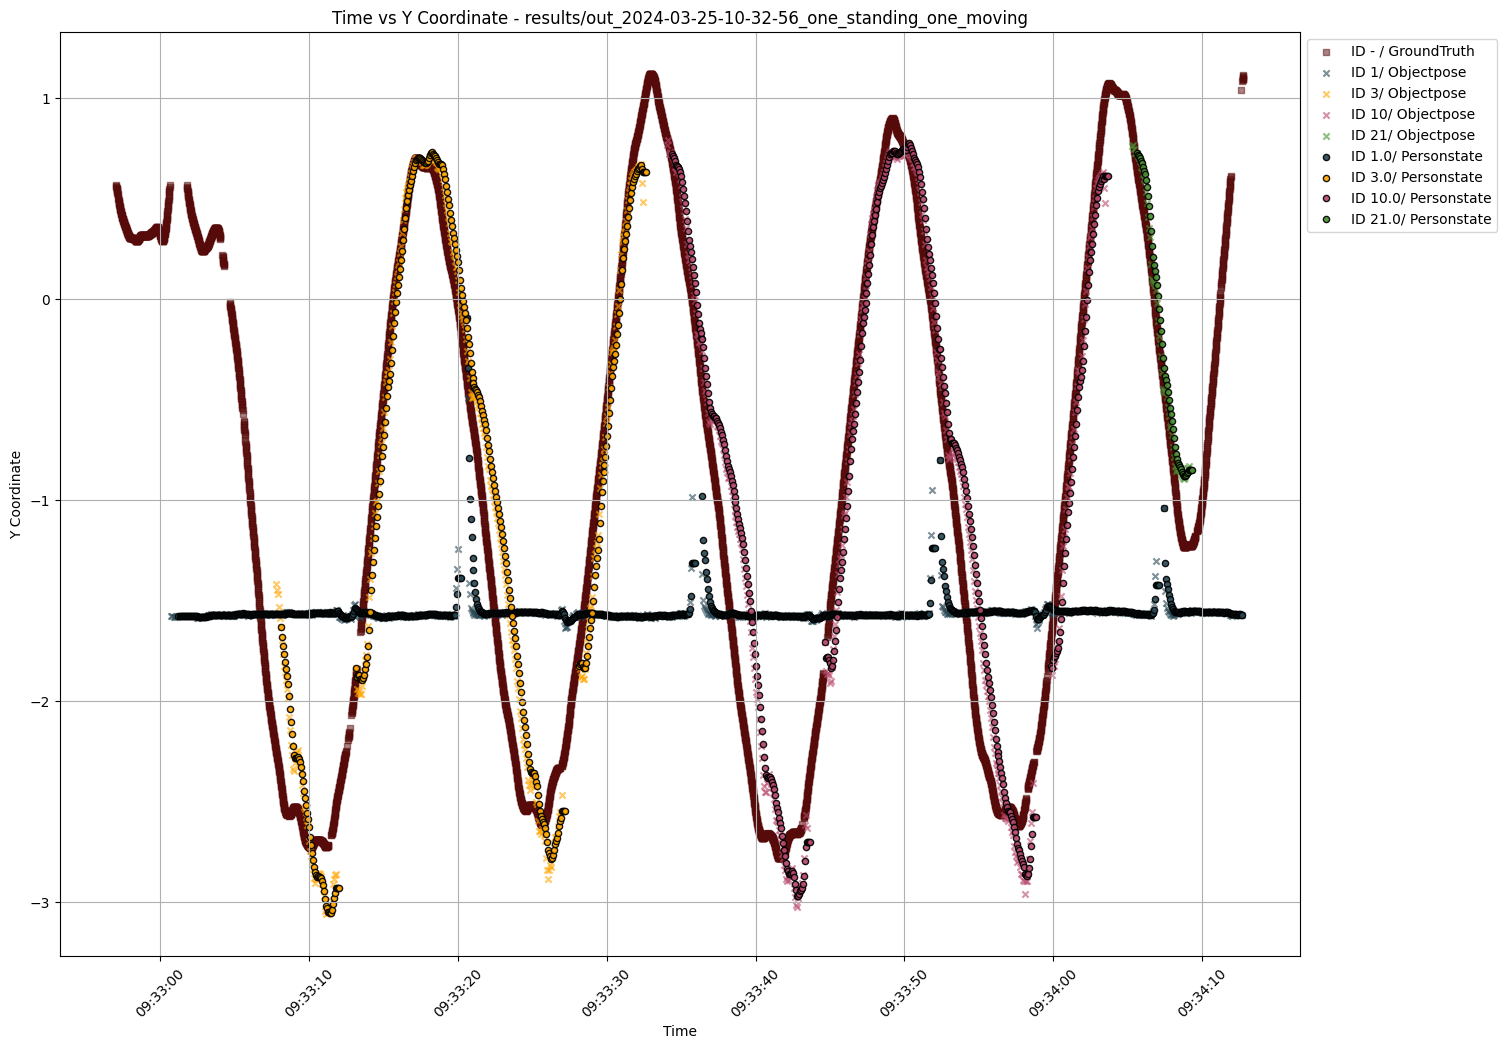

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


/tmp/ipykernel_183120/4130447133.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(person_df[xaxis], person_df[yaxis], label=f'ID {person_id}/ {topic}', color=id_colors[str(person_id)], edgecolor='black', marker=marker, alpha=alpha, s=20)


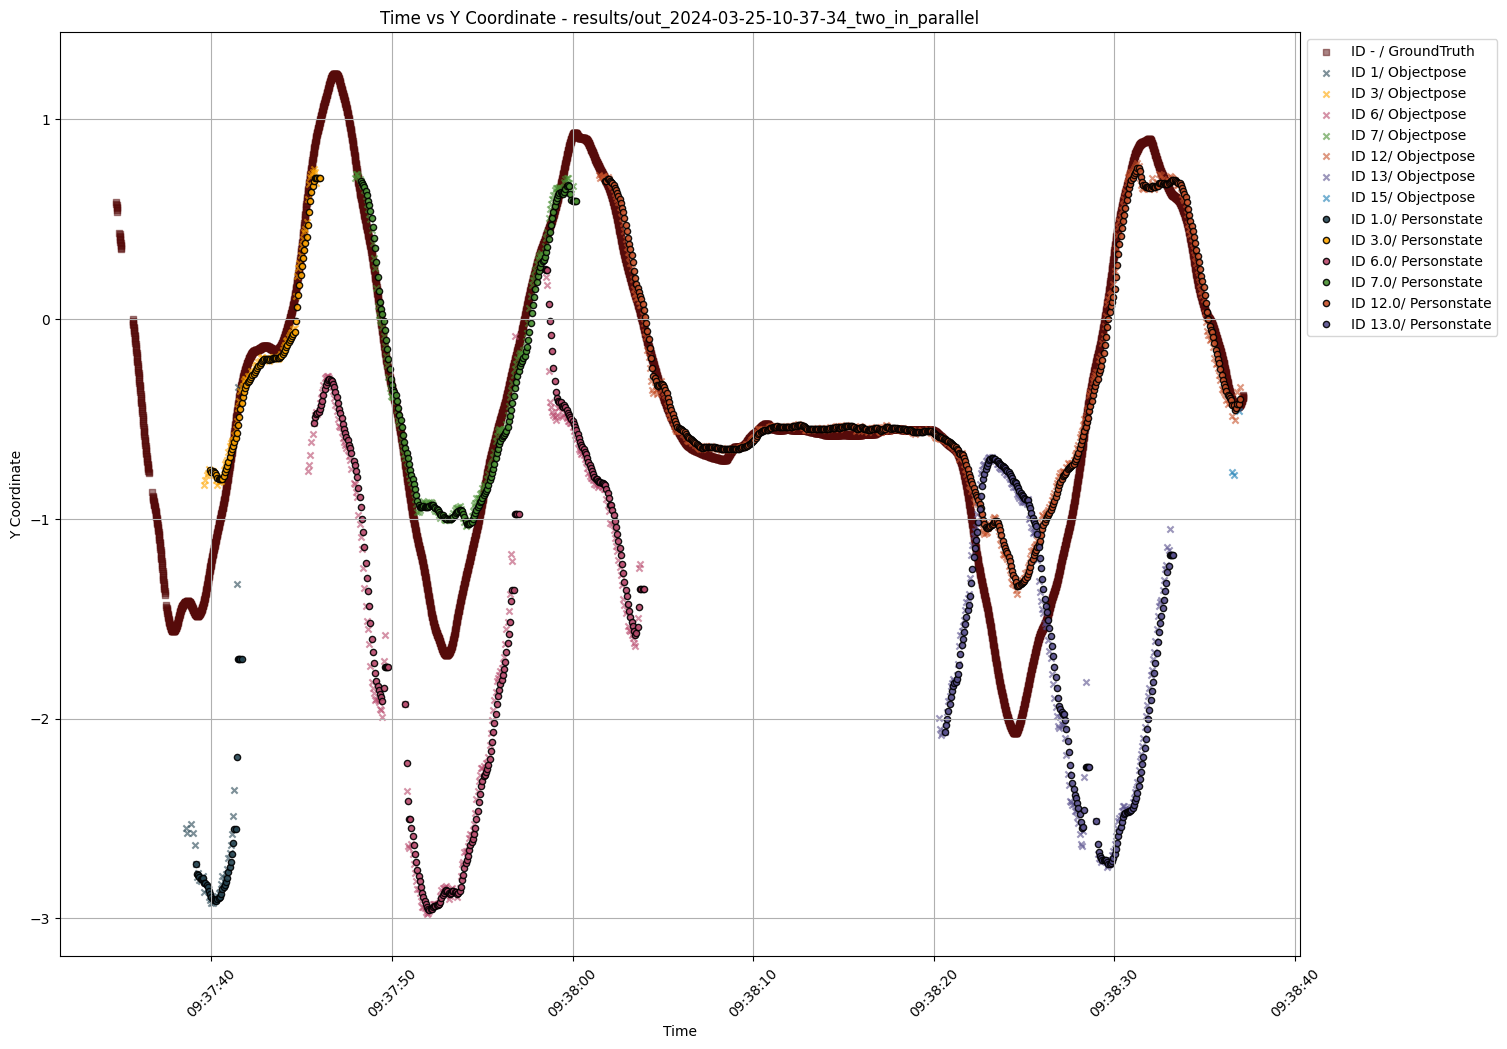

In [40]:
for file_path in data_paths:
    markers = [',', 's', 'x', 'o', "<"]

    file_path = 'results/' + file_path
    fig, ax = plt.subplots(figsize=(16, 12))
    for i, topic in enumerate(topics):
        print('topic:', topic)
        if 'velocity' in topic: continue
        df = read_data(file_path, topic)
        person_id_col, x_coord, y_coord, topic_label, alpha = get_topic_data(topic)
        plot_topic_for_persons(df, person_id_col, topic=topic_label, xaxis='time', yaxis=y_coord, marker=markers[i], ax=ax, alpha=alpha)

    ax.set_title(f"Time vs Y Coordinate - {file_path}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Y Coordinate")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    ax.grid(True)
    plt.xticks(rotation=45)
    plt.show()

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


/tmp/ipykernel_183120/4130447133.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(person_df[xaxis], person_df[yaxis], label=f'ID {person_id}/ {topic}', color=id_colors[str(person_id)], edgecolor='black', marker=marker, alpha=alpha, s=20)


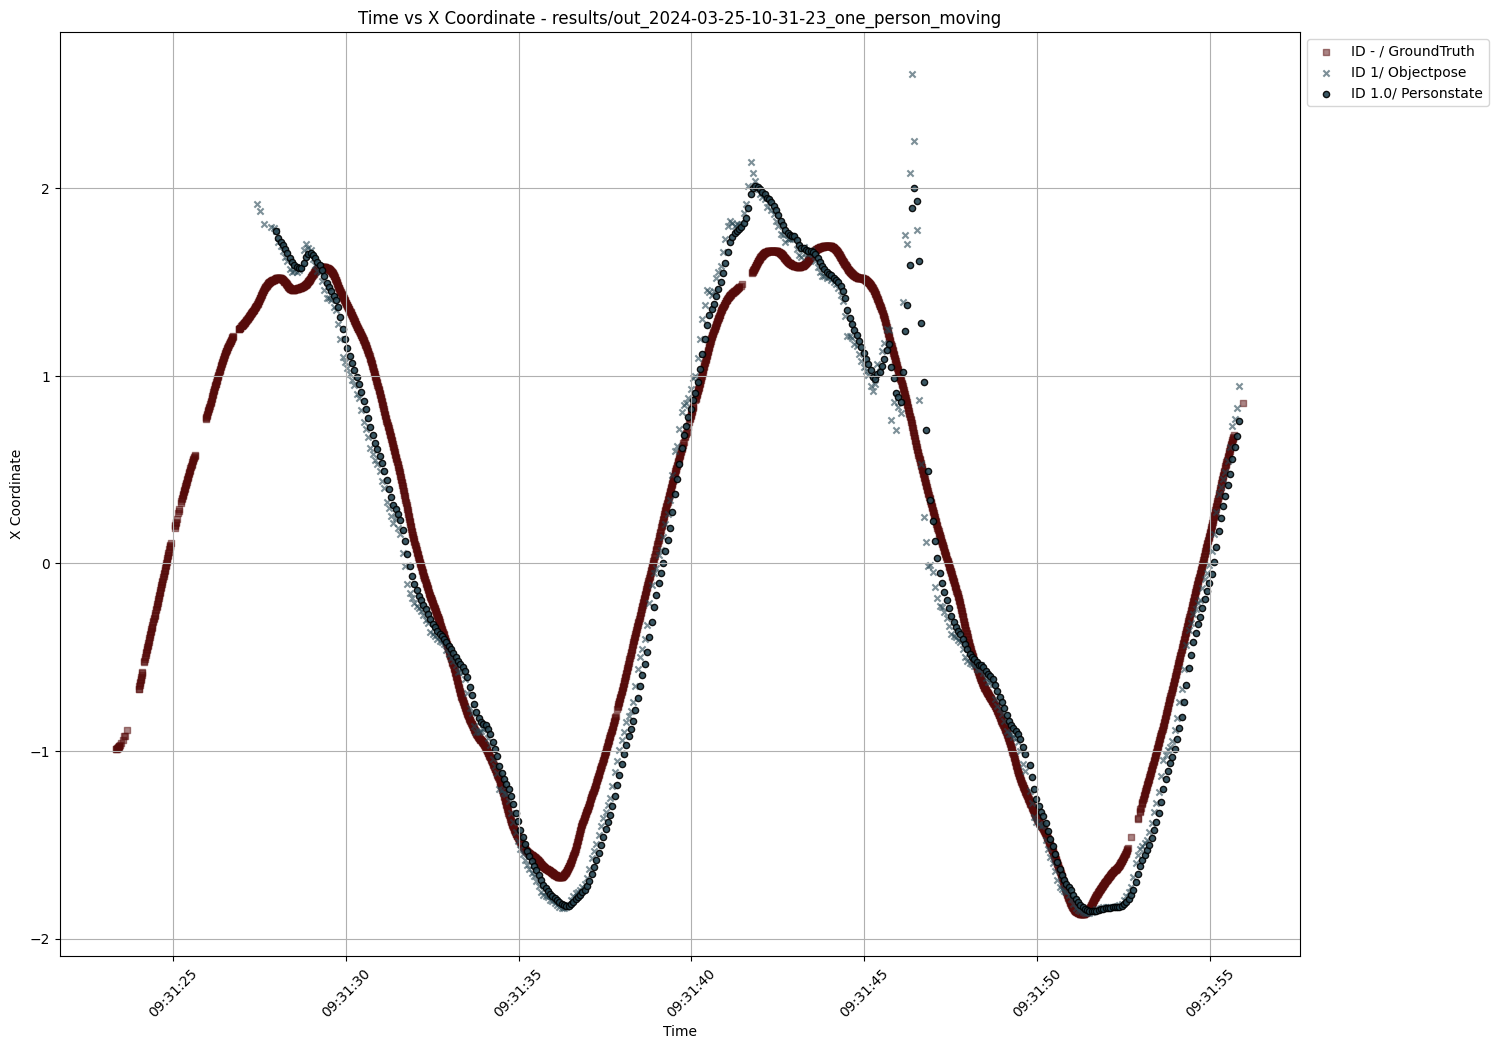

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


/tmp/ipykernel_183120/4130447133.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(person_df[xaxis], person_df[yaxis], label=f'ID {person_id}/ {topic}', color=id_colors[str(person_id)], edgecolor='black', marker=marker, alpha=alpha, s=20)


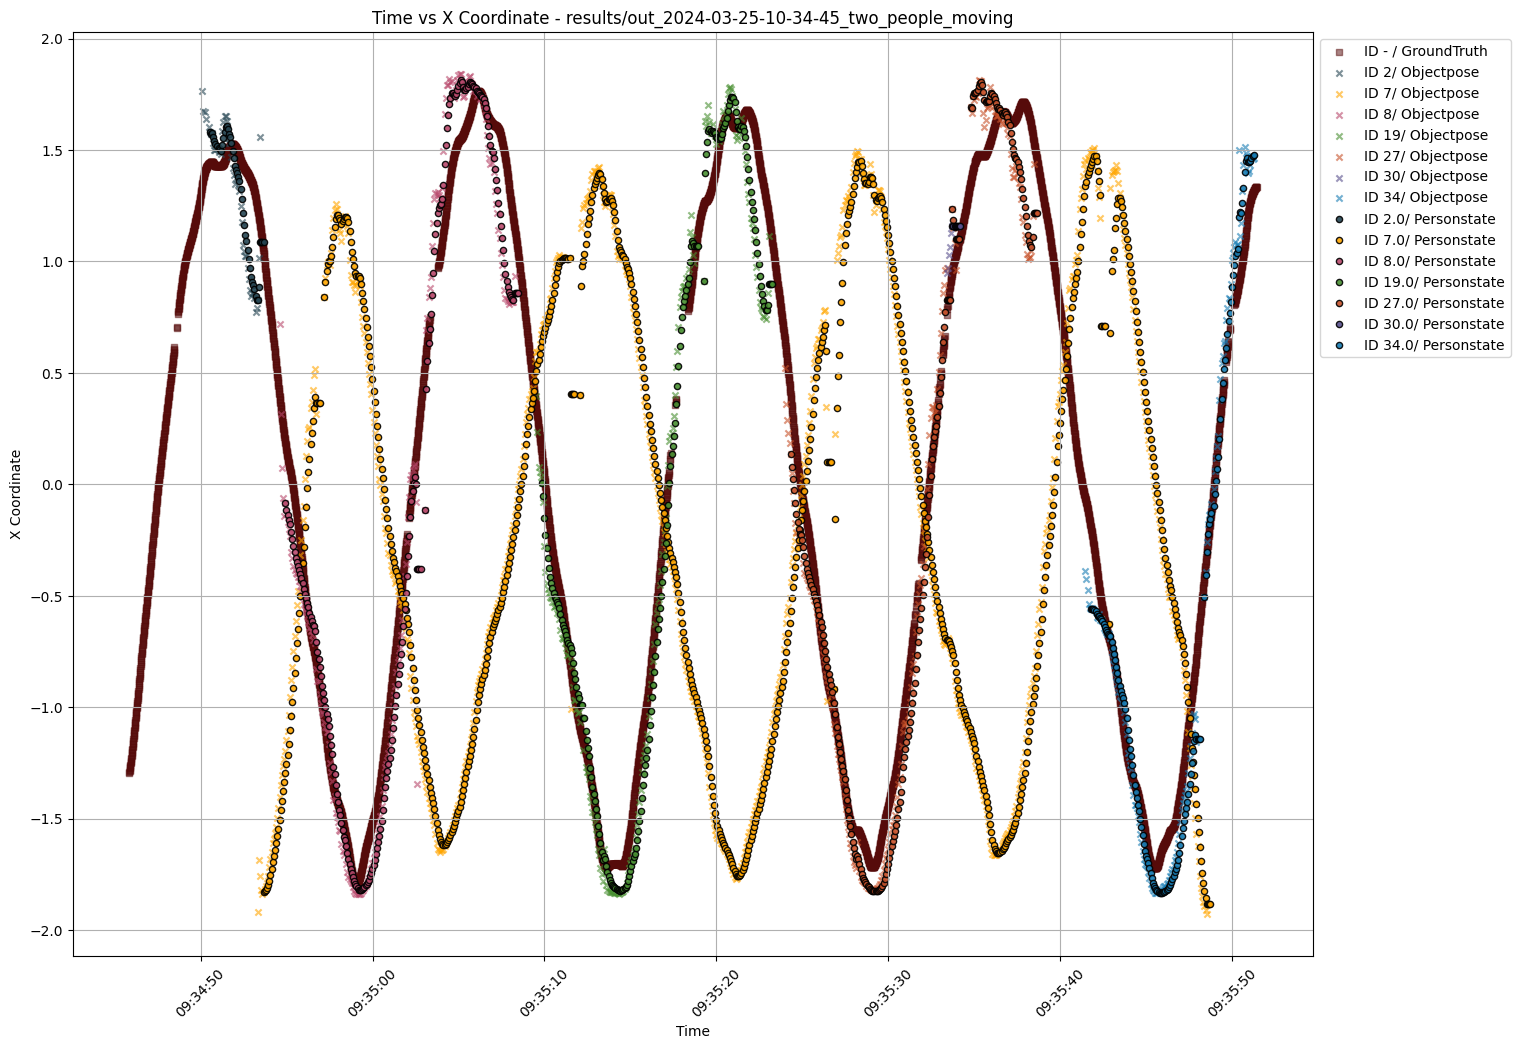

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


/tmp/ipykernel_183120/4130447133.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(person_df[xaxis], person_df[yaxis], label=f'ID {person_id}/ {topic}', color=id_colors[str(person_id)], edgecolor='black', marker=marker, alpha=alpha, s=20)


topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


/tmp/ipykernel_183120/4130447133.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(person_df[xaxis], person_df[yaxis], label=f'ID {person_id}/ {topic}', color=id_colors[str(person_id)], edgecolor='black', marker=marker, alpha=alpha, s=20)


In [41]:
for file_path in data_paths:
    markers = [',', 's', 'x', 'o', "<"]

    file_path = 'results/' + file_path
    fig, ax = plt.subplots(figsize=(16, 12))
    for i, topic in enumerate(topics):
        print('topic:', topic)
        if 'velocity' in topic: continue
        df = read_data(file_path, topic)
        person_id_col, x_coord, y_coord, topic_label, alpha = get_topic_data(topic)
        plot_topic_for_persons(df, person_id_col, topic=topic_label, xaxis='time', yaxis=x_coord, marker=markers[i], ax=ax, alpha=alpha)

    ax.set_title(f"Time vs X Coordinate - {file_path}")
    ax.set_xlabel("Time")
    ax.set_ylabel("X Coordinate")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    ax.grid(True)
    plt.xticks(rotation=45)
    plt.show()

In [42]:
topics = ['/_qualisys_pedestrian_pose.csv', '/_qualisys_pedestrian_velocity.csv',
'/_objectposes.csv', '/_person_state_estimation_person_states.csv']

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


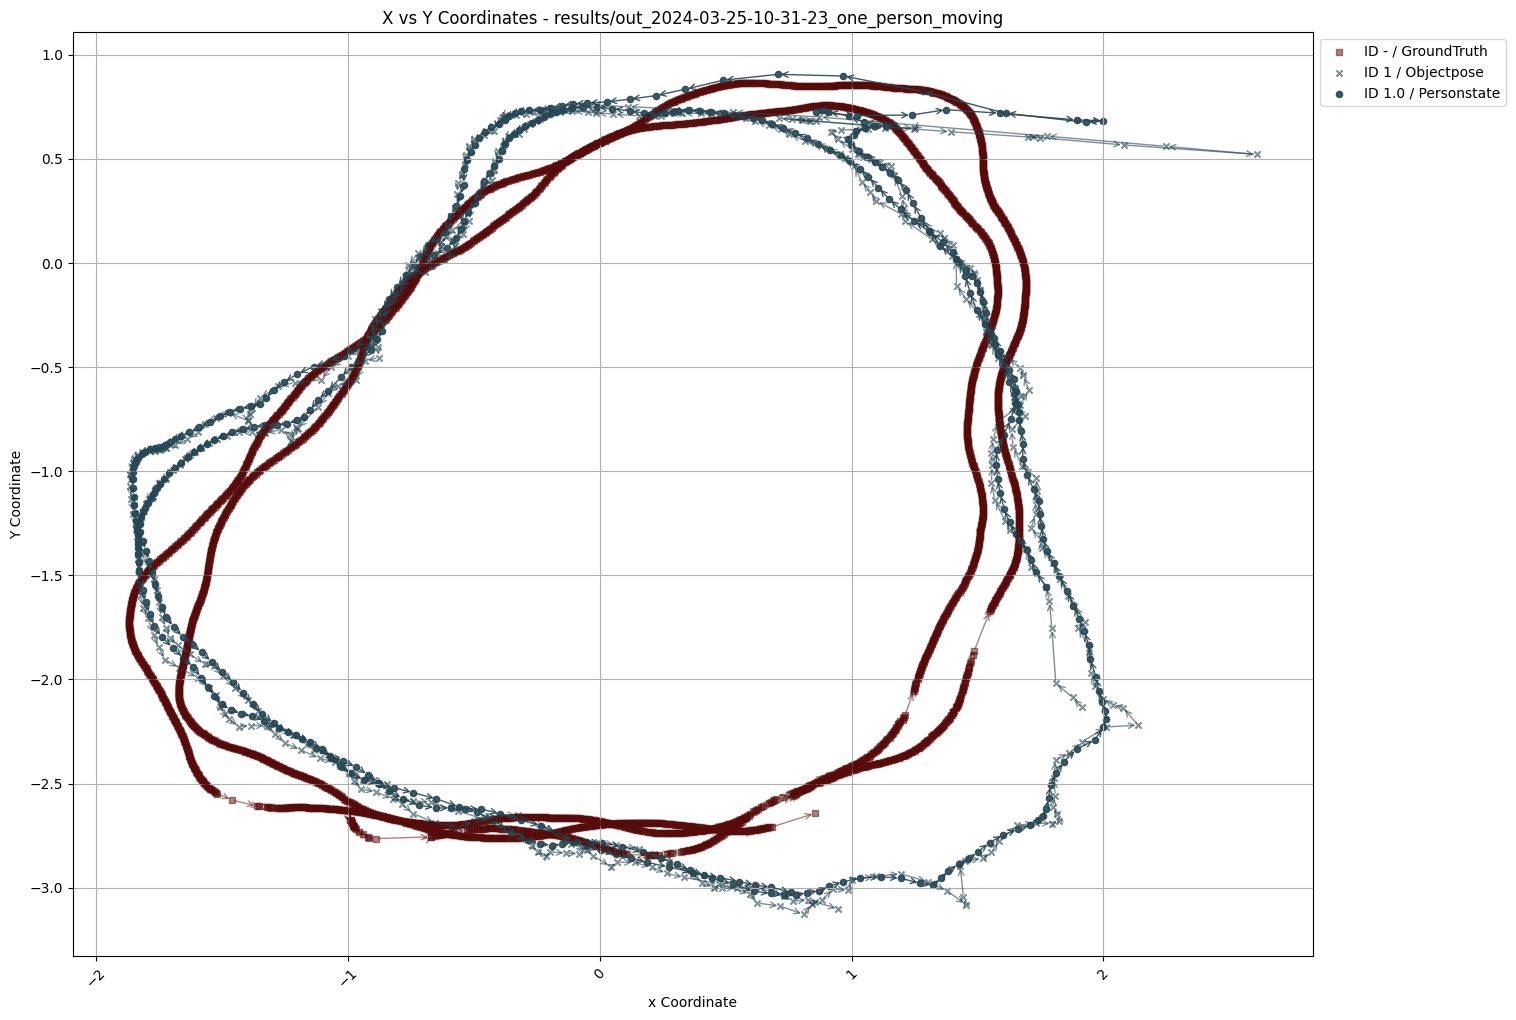

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


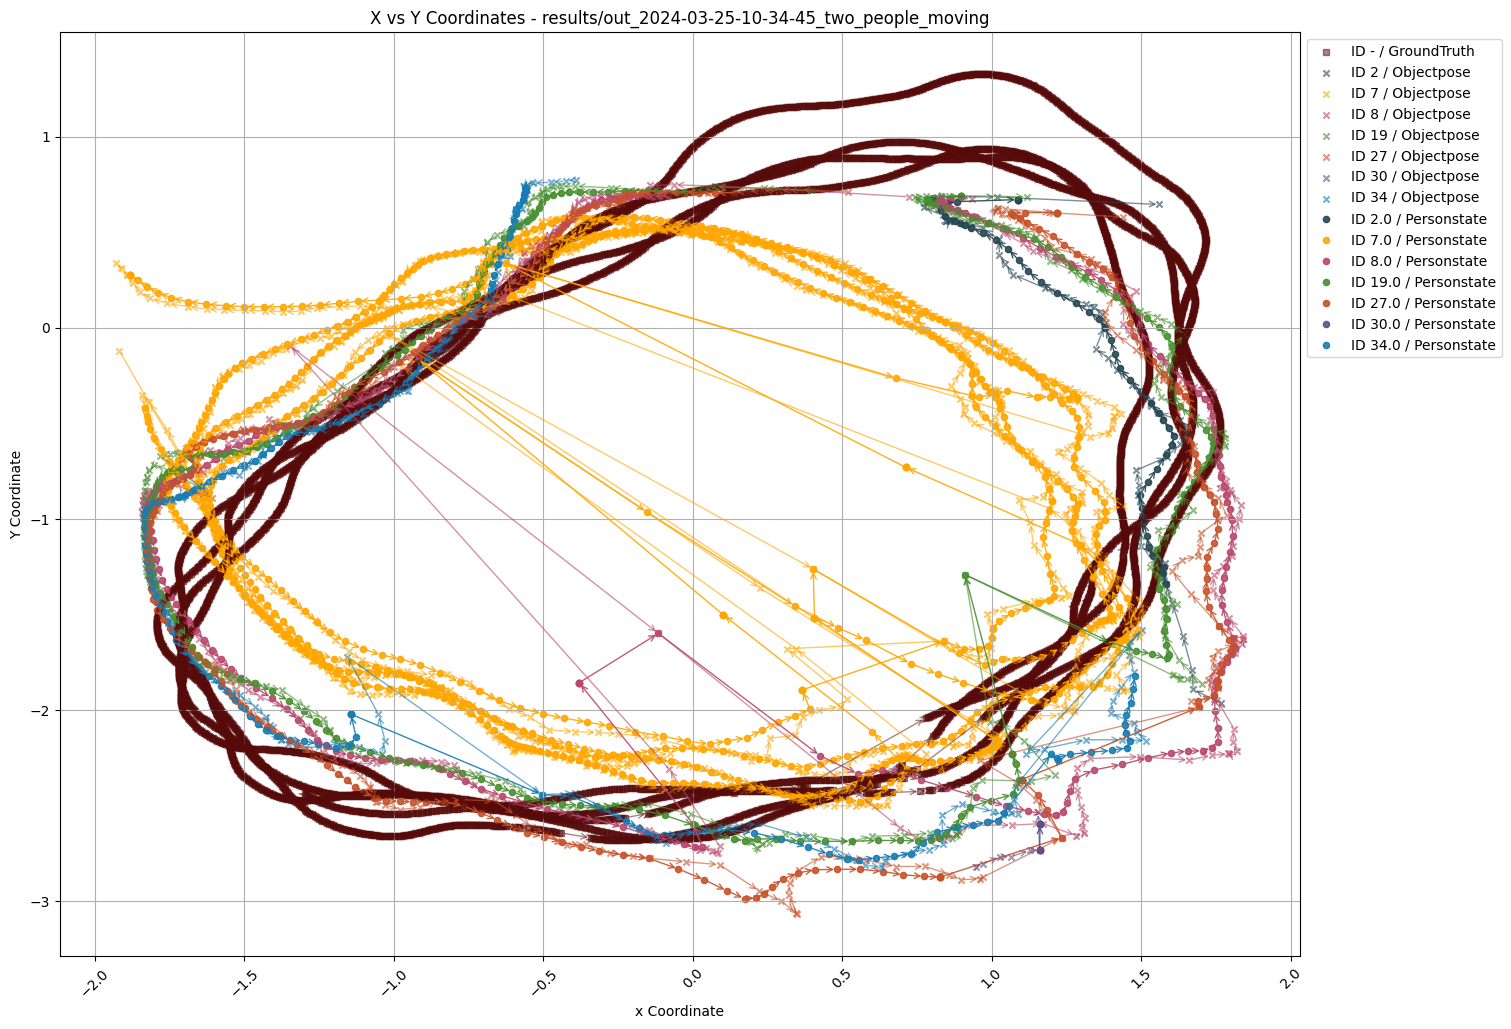

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


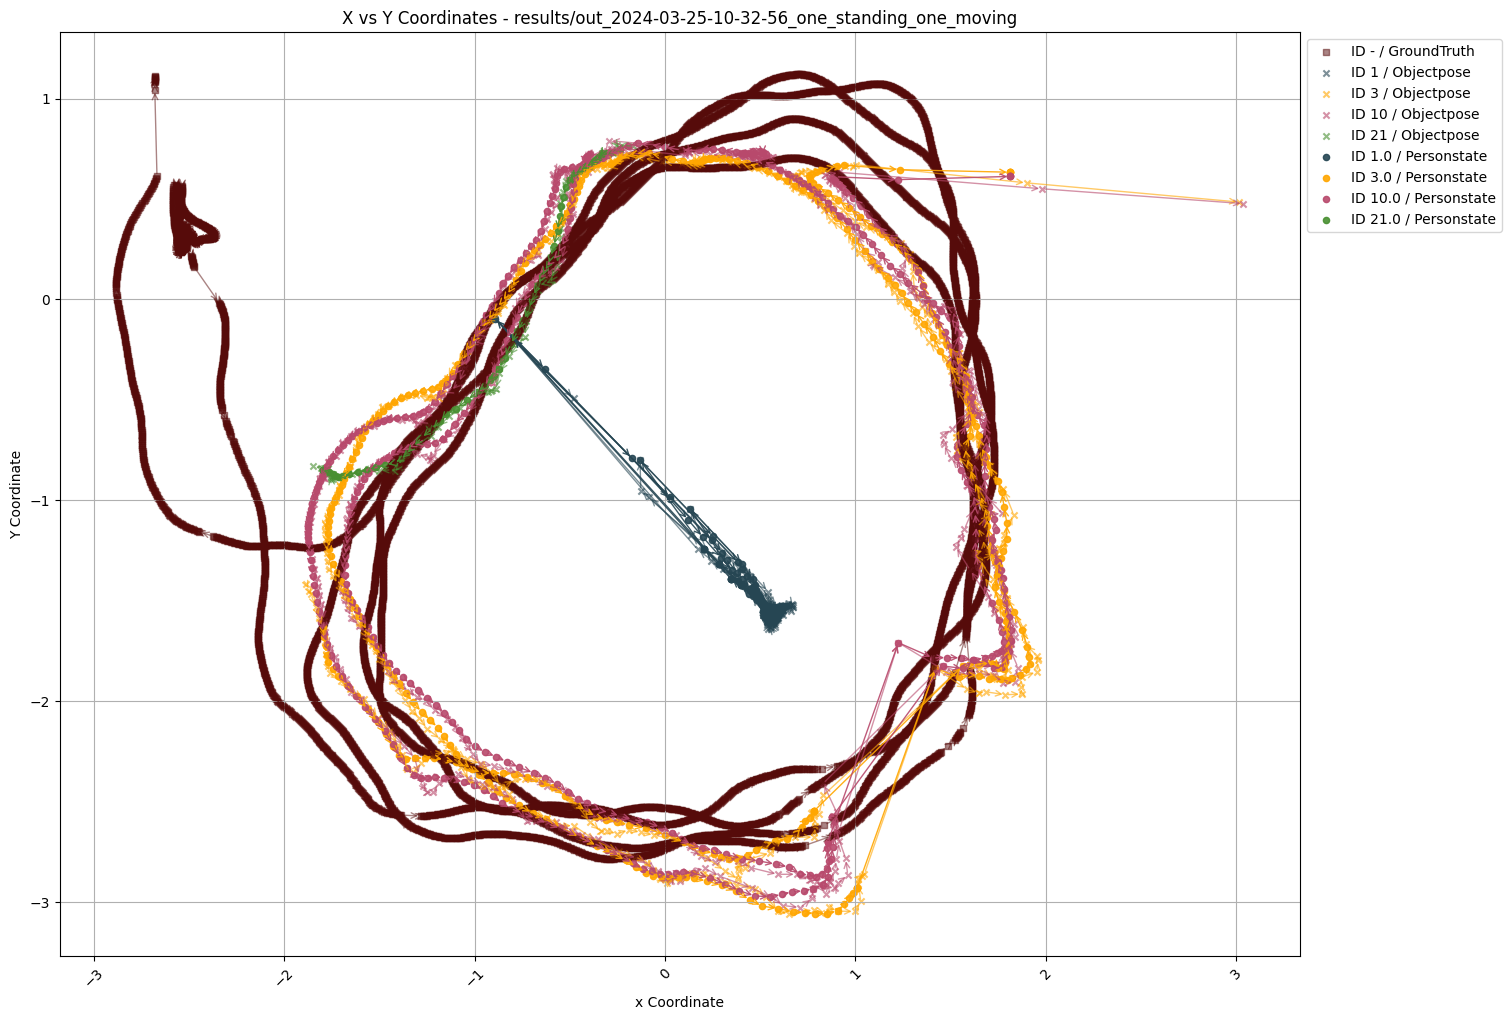

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


In [43]:
for file_path in data_paths:
    markers = [',', 's', 'x', 'o', "<"]

    file_path = 'results/' + file_path
    fig, ax = plt.subplots(figsize=(16, 12))
    for i, topic in enumerate(topics):
        print('topic:', topic)
        if 'velocity' in topic: continue
        df = read_data(file_path, topic)
        person_id_col, x_coord, y_coord, topic_label, alpha = get_topic_data(topic)
        plot_topic_for_persons_direction(df, person_id_col, topic=topic_label, xaxis=x_coord, yaxis=y_coord, marker=markers[i], ax=ax, alpha=alpha)

    ax.set_title(f"X vs Y Coordinates - {file_path}")
    ax.set_xlabel("x Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    ax.grid(True)
    plt.xticks(rotation=45)
    plt.show()